### load necessary modules

In [1]:
import uproot
import awkward as ak
import vector
vector.register_awkward()
from matplotlib import pyplot as plt
import mplhep as hep
hep.style.use("CMS")
import math
import itertools
import os
from typing import Dict, List, Tuple
from numpy.typing import ArrayLike
import numpy as np
import correctionlib
import awkward as ak
import fastjet
from coffea.nanoevents.methods import vector
from coffea import nanoevents
from coffea.analysis_tools import Weights, PackedSelection
from hist import Hist
ak.behavior.update(vector.behavior)
import sys
# from sklearn.metrics import roc_curve,auc
sys.path.append('/ospool/cms-user/yuzhe/LPRcalibration/HWWcalibration/LundReweighting/utils')
# sys.path.append('/ospool/cms-user/yuzhe/LPRcalibration/HWWcalibration/')
# import LundReweighter, PlotUtils
from LundReweighter import *
import pandas as pd


Welcome to JupyROOT 6.28/04


### Load signal NanoAOD files and do pre-selection 

In [2]:
#load signal files
events = nanoevents.NanoEventsFactory.from_root(
    #ggF HWW for example
    "/ospool/cms-user/yuzhe/CusNanoStore/HWWPFNano/2018/Signal/GluGluHToWW_Pt-200ToInf_M-125_TuneCP5_MINLO_13TeV-powheg-pythia8_RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2/out_11.root",
    schemaclass=nanoevents.NanoAODSchema,
).events()


In [5]:
#quick look at the fields of signal files
events.fields

['GenFatJetCands',
 'GenJetSVs',
 'TkMET',
 'L1simulation',
 'SV',
 'fixedGridRhoFastjetCentralNeutral',
 'GenCands',
 'DeepMETResponseTune',
 'fixedGridRhoFastjetAll',
 'HLTriggerFinalPath',
 'SoftActivityJetHT',
 'SoftActivityJetHT10',
 'SoftActivityJetNjets10',
 'GenJetAK8',
 'CorrT1METJet',
 'Generator',
 'SubJet',
 'LHEScaleWeight',
 'IsoTrack',
 'GenVtx',
 'GenSubJetAK15',
 'JetSVs',
 'SoftActivityJetNjets2',
 'SoftActivityJetHT2',
 'PSWeight',
 'FsrPhoton',
 'ChsMET',
 'btagWeight',
 'OtherPV',
 'SoftActivityJetHT5',
 'GenPart',
 'CaloMET',
 'L1PreFiringWeight',
 'fixedGridRhoFastjetCentralCalo',
 'MET',
 'LHEWeight',
 'PV',
 'fixedGridRhoFastjetCentral',
 'SoftActivityJet',
 'PFCands',
 'Electron',
 'genTtbarId',
 'LHE',
 'HTXS',
 'Muon',
 'run',
 'FatJet',
 'LHEPdfWeight',
 'GenJetAK15',
 'GenDressedLepton',
 'event',
 'HLT',
 'genWeight',
 'AK15Puppi',
 'GenIsolatedPhoton',
 'Flag',
 'JetPFCands',
 'PuppiMET',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'boostedTau',
 'FatJe

In [3]:
#pad array with given value
def pad_val(
    arr: ak.Array,
    target: int,
    value: float, #value can also be Bool variable 
    axis: int = 0,
    to_numpy: bool = True,
    clip: bool = True,
):
    """
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    padded_arr = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=axis)
    # pad_none will fill the array to target length with "None" for dedicated axis
    # "clip" means cut the array to the target length or not
    # fill_none will replace "None" value to some value
    return padded_arr.to_numpy() if to_numpy else padded_arr

def add_selection(
    name: str,
    sel: np.ndarray,
    selection: PackedSelection,
    cutflow: dict = None,
    isData: bool = False,
    signGenWeights: ak.Array = None,
):
    """adds selection to PackedSelection object and the cutflow dictionary"""
    selection.add(name, sel)
    if cutflow is not None: #only add to cutflow dictionary if cutflow is not None
        cutflow[name] = (
            np.sum(selection.all(*selection.names))
            if isData
            # add up sign of genWeights for MC
            else np.sum(signGenWeights[selection.all(*selection.names)])
        )


In [4]:
#pre-selection:
#1.Leading jet pT > 400GeV, maximum jet mass > 50GeV
#2.Require 2 or 3 AK8 jet with pT > 200GeV
#3.Veto (mini-)Isolated leptons
isData = False
signGenWeights = None if isData else np.sign(events["genWeight"]) #get genWeight sign, because only the sign matters
n_events = len(events) if isData else int(np.sum(signGenWeights)) #events number for MC events should be the sum of "sign"
selection = PackedSelection() #initialize a new object

cutflow = {}
# cutflow["all"] = len(events) #shouldn't be n_events?
cutflow["all"] = n_events
preselection_cut_vals = {"pt": 200, "msd": 20, "leading_pt":400,"maximum_mass":50}
num_jets = 2

# fatjets = corrections.get_jec_jets(events, "2018")
fatjets = events.FatJet

preselection_cut_1 = pad_val(
        ( ak.max(events.FatJet.pt, axis = 1) > preselection_cut_vals["leading_pt"])
        * (ak.max(events.FatJet.msoftdrop, axis = 1) > preselection_cut_vals["maximum_mass"]), #mass and pT cut of each jet in event
        len(events), #pad to num_jets length
        False,  #pad with value False
        )
# finally with the length of events number, "1" for all jets are pT > pT_cut and mass > mass_cut
 # N.B. here clip always = True

add_selection(
    "leading pT and maximum mass", #string name
    preselection_cut_1.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)



preselection_cut_2 = np.prod(
    pad_val(
        (events.FatJet.pt > preselection_cut_vals["pt"]),
        # * (events.FatJet.msoftdrop > preselection_cut_vals["msd"]), #mass and pT cut of each jet in event
        num_jets, #pad to num_jets length
        False,  #pad with value False
        axis=1, #pad to axis=1
    ),
    axis=1,
)# finally with the length of events number, "1" for all jets are pT > pT_cut and mass > mass_cut
 # N.B. here clip always = True

add_selection(
    "at least 2 AK8 jet with pT >200GeV", #string name
    preselection_cut_2.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)

preselection_cut_3 = pad_val(
        (ak.num(events.FatJet.pt) == 2) | (ak.num(events.FatJet.pt) == 3) , #mass and pT cut of each jet in event
        len(events), #pad to num_jets length
        False,  #pad with value False
        )

add_selection(
    "2 or 3 AK8 jet", #string name
    preselection_cut_3.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)


In [5]:
#veto (mini-)isolated muons
#referring to : https://github.com/farakiko/boostedhiggs/blob/ec53b97857bf64aa4d75f639e290181e65a55b4c/boostedhiggs/hwwprocessor.py#L185-L237
muons = ak.with_field(events.Muon, 0, "flavor")
electrons = ak.with_field(events.Electron, 1, "flavor")

# muons
loose_muons = (
    (((muons.pt > 30) & (muons.pfRelIso04_all < 0.25)) | (muons.pt > 55))
    & (np.abs(muons.eta) < 2.4)
    & (muons.looseId)
)
n_loose_muons = ak.sum(loose_muons, axis=1)
good_muons = (
    (muons.pt > 30)
    & (np.abs(muons.eta) < 2.4)
    & (np.abs(muons.dz) < 0.1)
    & (np.abs(muons.dxy) < 0.05)
    & (muons.sip3d <= 4.0)
    & muons.mediumId
)
n_good_muons = ak.sum(good_muons, axis=1)

# electrons
loose_electrons = (
    (((electrons.pt > 38) & (electrons.pfRelIso03_all < 0.25)) | (electrons.pt > 120))
    & (np.abs(electrons.eta) < 2.4)
    & ((np.abs(electrons.eta) < 1.44) | (np.abs(electrons.eta) > 1.57))
    & (electrons.cutBased >= electrons.LOOSE)
)
n_loose_electrons = ak.sum(loose_electrons, axis=1)
good_electrons = (
    (electrons.pt > 38)
    & (np.abs(electrons.eta) < 2.4)
    & ((np.abs(electrons.eta) < 1.44) | (np.abs(electrons.eta) > 1.57))
    & (np.abs(electrons.dz) < 0.1)
    & (np.abs(electrons.dxy) < 0.05)
    & (electrons.sip3d <= 4.0)
    & (electrons.mvaFall17V2noIso_WP90)
)
n_good_electrons = ak.sum(good_electrons, axis=1)

n_leptons = n_loose_electrons + n_good_electrons + n_loose_muons + n_good_muons

preselection_cut_4 = pad_val(
        (n_leptons == 0) , #mass and pT cut of each jet in event
        len(events), #pad to num_jets length
        False,  #pad with value False
        )

add_selection(
    "no (mini-)isolated leptons", #string name
    preselection_cut_4.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)


In [6]:
#require WW decaying to 4q, because we want to calibrate H3q4q jet at first stage
d_PDGID = 1
u_PDGID = 2
s_PDGID = 3
c_PDGID = 4
b_PDGID = 5
g_PDGID = 21
TOP_PDGID = 6

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25
Y_PDGID = 35

b_PDGIDS = [511, 521, 523]

GRAV_PDGID = 39

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

FILL_NONE_VALUE = -99999
PAD_VAL = -99999

skim_vars = {
    "eta": "Eta",
    "phi": "Phi",
    "mass": "Mass",
    "pt": "Pt",
}

In [7]:
# finding the gen higgs
higgs = events.GenPart[
    (abs(events.GenPart.pdgId) == HIGGS_PDGID) * events.GenPart.hasFlags(GEN_FLAGS)
]
# saving 4-vector info
GenHiggsVars = {f"GenHiggs{key}": higgs[var].to_numpy() for (var, key) in skim_vars.items()}

higgs_children = higgs.children

# saving whether H->bb or H->VV
GenHiggsVars["GenHiggsChildren"] = abs(higgs_children.pdgId[:, :, 0]).to_numpy()

# finding WW children
is_WW = abs(higgs_children.pdgId) == W_PDGID

# Hbb = higgs[ak.sum(is_bb, axis=2) == 2]
HWW = higgs[ak.sum(is_WW, axis=2) == 2]

# checking that there are 2 b's and 2 V's
has_WW = ak.sum(ak.flatten(is_WW, axis=2), axis=1) == 2

# saving WW 4-vector info
WW = ak.flatten(higgs_children[is_WW], axis=2)
GenWWVars = {
    f"GenWW{key}": WW[var].to_numpy() for (var, key) in skim_vars.items()
    }

# checking that each W has 2 q children, so finally the HWW jet will be H4q or H3q jet
WW_children = WW.children

quarks = abs(WW_children.pdgId) <= b_PDGID #get all the 2 Ws daughter PDGID <=5 information

selection_all_q = ak.all(ak.all(quarks, axis=2), axis=1) #check if all the children of 2 Ws are quarks or not
#so first check 2nd axis, and then check 1st axis
add_selection(
    "WW decays to 4q",
    selection_all_q, 
    selection, 
    cutflow, 
    False, 
    signGenWeights)
# print(selection_all_q)


In [8]:
#quick look at the cut-flow
cutflow

{'all': 29982,
 'leading pT and maximum mass': 2172.0,
 'at least 2 AK8 jet with pT >200GeV': 2096.0,
 '2 or 3 AK8 jet': 2046.0,
 'no (mini-)isolated leptons': 1584.0,
 'WW decays to 4q': 1064.0}

### store the PFCands, GenEtaPhi, Higgs candidate AK8 jet 4-vector information for Lund Plane use

In [9]:
events_after_cut = events[selection.all(*selection.names)]
events_after_cut

<NanoEventsArray [<event 1:37:36013>, ... ] type='1066 * event'>

In [10]:
#find the Higgs jet idx, dR(gen_Higgs, jet)<0.8 & dR(gen_W_1, jet)<0.8 & dR(gen_W_2, jet)<0.8

#collect gen-Higgs information
higgs = events_after_cut.GenPart[
    (abs(events_after_cut.GenPart.pdgId) == HIGGS_PDGID) * events_after_cut.GenPart.hasFlags(GEN_FLAGS)
]
GenHiggsVars = {
    f"GenHiggs{key}": higgs[var].to_numpy() for (var, key) in skim_vars.items()
    }
higgs_children = higgs.children

# collect gen-Higgs children WW information, may not be used, since only Higgs information is needed for the matching
is_WW = abs(higgs_children.pdgId) == W_PDGID
WW = ak.flatten(higgs_children[is_WW], axis=2)

GenWWVars = {
    f"GenWW{key}": WW[var].to_numpy() for (var, key) in skim_vars.items()
    }
GenW1Vars = {
    f"GenWW{key}": WW[var][:,0].to_numpy() for (var, key) in skim_vars.items()
    }
GenW2Vars = {
    f"GenWW{key}": WW[var][:,1].to_numpy() for (var, key) in skim_vars.items()
    }

#collect FatJet information
fatjets = events_after_cut.FatJet
HWW = ak.pad_none(higgs, 1, axis=1, clip=True)[:, 0] #because it's a 2D array
WWdr = fatjets[:, :3].delta_r(HWW) #here use 3 because we have up to 3 AK8 jets, use ak.max(ak.num(WWdr,axis = 1)) for test
match_dR = 0.8
HWW_match = WWdr <= match_dR #FatJetIdx in each event, which is real HWW jet
HWWJets = ak.pad_none(fatjets[HWW_match], 1, axis=1)[:, 0] #There can be None object in HWWJets array
#tie [pt, eta, phi, mass] together, get new arrary




In [11]:
HWWJets.pt

<Array [203, 424, 458, 394, ... 418, 702, 440] type='1066 * ?float32[parameters=...'>

In [11]:
filled_pt = pad_val(HWWJets.pt,len(HWWJets.pt),-99)
# i = np.where(selection_has_HWWjet == False)
# i
# selection_has_HWWjet
selection_has_HWWjet = filled_pt > 0
selection_has_HWWjet

array([ True,  True,  True, ...,  True,  True,  True])

In [13]:
events_after_cut

<NanoEventsArray [<event 1:37:36013>, ... ] type='1066 * event'>

In [12]:
# selection_has_HWWjet = ak.Array(HWWJets.pt != None)
events_final = events_after_cut[selection_has_HWWjet]
len(events_final)
events_final

<NanoEventsArray [<event 1:37:36013>, ... ] type='1026 * event'>

### Do it again after the final cut

In [13]:
#find the Higgs jet idx, dR(gen_Higgs, jet)<0.8 & dR(gen_W_1, jet)<0.8 & dR(gen_W_2, jet)<0.8

#collect gen-Higgs information
higgs = events_final.GenPart[
    (abs(events_final.GenPart.pdgId) == HIGGS_PDGID) * events_final.GenPart.hasFlags(GEN_FLAGS)
]
GenHiggsVars = {
    f"GenHiggs{key}": higgs[var].to_numpy() for (var, key) in skim_vars.items()
    }
higgs_children = higgs.children

# collect gen-Higgs children WW information, may not be used, since only Higgs information is needed for the matching
is_WW = abs(higgs_children.pdgId) == W_PDGID
WW = ak.flatten(higgs_children[is_WW], axis=2)

GenWWVars = {
    f"GenWW{key}": WW[var].to_numpy() for (var, key) in skim_vars.items()
    }
GenW1Vars = {
    f"GenWW{key}": WW[var][:,0].to_numpy() for (var, key) in skim_vars.items()
    }
GenW2Vars = {
    f"GenWW{key}": WW[var][:,1].to_numpy() for (var, key) in skim_vars.items()
    }

#collect FatJet information
fatjets = events_final.FatJet
HWW = ak.pad_none(higgs, 1, axis=1, clip=True)[:, 0] #because it's a 2D array
WWdr = fatjets[:, :3].delta_r(HWW) #here use 3 because we have up to 3 AK8 jets, use ak.max(ak.num(WWdr,axis = 1)) for test
match_dR = 0.8
HWW_match = WWdr <= match_dR #FatJetIdx in each event, which is real HWW jet
HWWJets = ak.pad_none(fatjets[HWW_match], 1, axis=1)[:, 0] #There can be None object in HWWJets array
#tie [pt, eta, phi, mass] together, get new arrary


WW_children = WW.children

quarks = abs(WW_children.pdgId) <= b_PDGID #get all the 2 Ws daughter PDGID <=5 information
print(quarks)

# saving 4q 4-vector info
Gen4qVars = {
    f"Gen4q{key}": ak.to_numpy(
        ak.fill_none(
            ak.pad_none(ak.pad_none(WW_children[var], 2, axis=1, clip=True), 2, axis=2, clip=True),
            FILL_NONE_VALUE,
        )
    )
    for (var, key) in skim_vars.items()
}
len(Gen4qVars["Gen4qPt"])

[[[True, True], [True, True]], [[True, ... True]], [[True, True], [True, True]]]


1026

In [254]:
HWWJets.mass

<Array [99.8, 143, 103, 127, ... 142, 130, 124] type='1026 * ?float32[parameters...'>

In [191]:
i = np.where(HWWJets.pt == None)
i

(<Array [63, 91, 96, 102, ... 971, 999, 1056] type='40 * int64'>,)

In [181]:
pt_array = pad_val(HWWJets.pt,len(HWWJets.pt),-999)

In [185]:
i = np.where(pt_array == -999)
i

(array([  63,   91,   96,  102,  129,  170,  171,  199,  219,  232,  270,
         278,  314,  334,  344,  356,  361,  367,  374,  392,  396,  418,
         443,  485,  518,  524,  556,  600,  618,  634,  668,  677,  715,
         744,  752,  854,  874,  971,  999, 1056]),)

In [167]:
HWWJets.eta

<Array [-0.219, 0.384, 0.29, ... -1.17, 1.23] type='1066 * ?float32[parameters={...'>

In [219]:
HWWJets.phi

<Array [-0.204, -2.24, -0.37, ... -1.75, 2.79] type='1026 * ?float32[parameters=...'>

### four vector for HWW jet

In [14]:
# four vector for HWW jet
higgs_jet_4vec = np.array(np.stack((np.array(HWWJets.pt), np.array(HWWJets.eta),np.array(HWWJets.phi),np.array(HWWJets.mass)), axis=1))
higgs_jet_4vec[1]

array([ 4.2400000e+02,  3.8409424e-01, -2.2407227e+00,  1.4275000e+02],
      dtype=float32)

In [284]:
higgs_jet_4vec[1]

array([ 4.2400000e+02,  3.8409424e-01, -2.2407227e+00,  1.4275000e+02],
      dtype=float32)

### Next eta-phi for 4 quarks

In [261]:
a = Gen4qVars["Gen4qEta"][:2]
a

masked_array(
  data=[[[-0.89453125,  0.04370117],
         [-0.08032227, -0.625     ]],

        [[ 0.28027344,  0.42871094],
         [ 0.46484375,  0.55078125]]],
  mask=False,
  fill_value=1e+20)

In [268]:
a = Gen4qVars["Gen4qEta"]
a_2 = a.reshape(a.shape[0], -1)
a_2

masked_array(
  data=[[-0.89453125,  0.04370117, -0.08032227, -0.625     ],
        [ 0.28027344,  0.42871094,  0.46484375,  0.55078125]],
  mask=False,
  fill_value=1e+20)

In [270]:
b = Gen4qVars["Gen4qPhi"][:2]
b_2 = b.reshape(b.shape[0], -1)
b_2

masked_array(
  data=[[ 1.171875  , -0.00447083, -0.51757812,  0.43652344],
        [-2.2890625 , -1.6015625 , -2.1015625 , -2.6484375 ]],
  mask=False,
  fill_value=1e+20)

In [274]:
ab = np.dstack((a_2,b_2))
ab

masked_array(
  data=[[[-0.89453125,  1.171875  ],
         [ 0.04370117, -0.00447083],
         [-0.08032227, -0.51757812],
         [-0.625     ,  0.43652344]],

        [[ 0.28027344, -2.2890625 ],
         [ 0.42871094, -1.6015625 ],
         [ 0.46484375, -2.1015625 ],
         [ 0.55078125, -2.6484375 ]]],
  mask=False,
  fill_value=1e+20)

In [15]:
# Finally construct the eta-phi array
eta = Gen4qVars["Gen4qEta"].reshape(Gen4qVars["Gen4qEta"].shape[0], -1)
phi = Gen4qVars["Gen4qPhi"].reshape(Gen4qVars["Gen4qPhi"].shape[0], -1)
gen_parts_eta_phi = np.array(np.dstack((eta,phi)))
# can do test like : gen_parts_eta_phi[:2]

In [ ]:
higgs_jet_4vec[0]

<Array [203, -0.219, -0.204, 99.8] type='4 * float32'>

In [ ]:
higgs_jet = ak.zip({"pt": eventsTest.GenPart_pt, "eta": eventsTest.GenPart_eta, "phi": eventsTest.GenPart_phi, "mass": eventsTest.GenPart_mass, "pdgId": eventsTest.GenPart_pdgId, "status": eventsTest.GenPart_status, "genPartIdxMother": eventsTest.GenPart_genPartIdxMother}, with_name="LorentzVector")

In [135]:
GenWWVars["GenWWPhi"]

masked_array(
  data=[[ 0.24804688, -0.28515625],
        [-2.1875    , -2.4140625 ],
        [-0.36914062, -0.46777344],
        ...,
        [-2.9921875 , -3.        ],
        [-1.7851562 , -1.6914062 ],
        [ 2.8515625 ,  2.75      ]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [134]:
GenW1Vars["GenWWPhi"]

masked_array(data=[ 0.24804688, -2.1875    , -0.36914062, ...,
                   -2.9921875 , -1.7851562 ,  2.8515625 ],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [106]:
ak.max(events_after_cut.FatJetPFCands.jetIdx) 
#means jetIdx can go up to 2, since we require 2 or 3 AK8 jet
#but if you use ak.max(events.FatJetPFCands.jetIdx), it can go up to 4, means there are 5 AK8 jets.

2

In [42]:
import awkward as ak

# 创建一个示例的不规则 Awkward 数组
arr = ak.Array([[1, 2, 3], [4, 5], [6, 7, 8, 9], [10]])

# 使用 ak.num 获取每个子数组的长度
subarray_lengths = ak.num(arr)

# 使用 ak.max 获取最长的子数组长度
max_length = ak.max(subarray_lengths)

# 打印最长的子数组长度
print("最长的子数组长度：", max_length)


最长的子数组长度： 4


### Get FatJetPFCands 4-vector, up to 100 length to suit the input of Oz's function

In [16]:
# first get the jet_idx HWW jet, each event has one jet_idx
HWW_match = WWdr <= match_dR #FatJetIdx in each event, which is real HWW jet
HWW_match_padded = pad_val(HWW_match,3,False,1,True) #pad the array with False value
HWW_jet_idx = np.argmax(HWW_match_padded,axis = 1) #the jet index in each jet which is true HWW jet
# then get all the FatJetPFCands according to the jet_idx, and get PF_idx
HWW_FatJetPFCands = (events_final.FatJetPFCands.jetIdx == HWW_jet_idx)
HWW_FatJetPFCands_pFCandsIdx = events_final.FatJetPFCands.pFCandsIdx[HWW_FatJetPFCands]
# at last, get PFCands 4-vector according to the PF_idx in last step


In [17]:
index_array = ak.to_list(HWW_FatJetPFCands_pFCandsIdx)

In [18]:
pt_array = events_final.PFCands.pt
eta_array = events_final.PFCands.eta
phi_array = events_final.PFCands.phi
mass_array = events_final.PFCands.mass

In [67]:
print(ak.max(ak.num(index_array)))

105


In [33]:
index_array[0][3]

16

In [34]:
pt_array[0][16]

3.044921875

In [35]:
selected_pt[0][3]

3.044921875

In [19]:
selected_pt = [[pt_array[i][j] for j in indices] for i, indices in enumerate(index_array)]

In [20]:
selected_eta = [[eta_array[i][j] for j in indices] for i, indices in enumerate(index_array)]

In [21]:
selected_phi = [[phi_array[i][j] for j in indices] for i, indices in enumerate(index_array)]

In [22]:
selected_mass = [[mass_array[i][j] for j in indices] for i, indices in enumerate(index_array)]

In [23]:
selected_pt_padded = pad_val(selected_pt,150,0,1,True)
selected_eta_padded = pad_val(selected_eta,150,0,1,True)
selected_phi_padded = pad_val(selected_phi,150,0,1,True)
selected_mass_padded = pad_val(selected_mass,150,0,1,True)

In [81]:
len(selected_pt[2])

38

In [80]:
len(selected_eta[2])

38

In [24]:
pf_cands = np.dstack((selected_pt_padded,selected_eta_padded,selected_phi_padded,selected_mass_padded))

In [25]:
pf_cands[0]

array([[ 8.81835938e-01, -5.49316406e-02, -1.05651855e-01,
         1.39526367e-01],
       [ 7.26074219e-01, -4.67285156e-01,  4.90661621e-01,
         1.39526367e-01],
       [ 5.91308594e-01, -6.33544922e-01,  4.83886719e-01,
         1.39526367e-01],
       [ 3.04492188e+00, -1.35498047e-02, -1.72363281e-01,
         1.39526367e-01],
       [ 9.98046875e-01,  1.12609863e-01, -2.38098145e-01,
         1.39526367e-01],
       [ 1.35644531e+00,  1.01074219e-01, -3.18450928e-02,
         1.39526367e-01],
       [ 1.96679688e+00,  6.07910156e-02, -2.32467651e-02,
         1.39526367e-01],
       [ 8.82812500e+00,  2.17895508e-02, -9.56916809e-03,
         1.39526367e-01],
       [ 1.38769531e+00,  8.05664062e-03,  1.86126709e-01,
         1.39526367e-01],
       [ 1.40234375e+01, -3.71704102e-02,  2.20718384e-02,
         3.56674194e-03],
       [ 3.09960938e+00, -5.36499023e-02,  1.64764404e-01,
         1.39526367e-01],
       [ 3.49804688e+00, -9.10034180e-02, -1.86500549e-02,
      

In [73]:
selected_eta[0][2]

-0.633544921875

In [44]:
HWW_FatJetPFCands_pFCandsIdx = events_final.FatJetPFCands.pFCandsIdx[HWW_FatJetPFCands]
HWW_FatJetPFCands_pFCandsIdx[0]

<Array [0, 5, 8, 16, ... 144, 155, 157, 160] type='73 * int32[parameters={"__doc...'>

In [41]:
print(ak.max(ak.num(HWW_FatJetPFCands_pFCandsIdx))) 
# we can use 150 as the length of PFCands array, after all in the LundReweighter module, PFCands with mass less than 0.0001 will  not be used, 
# for the reference, see:https://github.com/OzAmram/LundReweighting/blob/5fc5543e2056b58f3095d678d53498bf93f18765/utils/LundReweighter.py#L165

105


In [26]:
events_final.FatJetPFCands.jetIdx[0]

<Array [0, 0, 0, 0, 0, 0, ... 2, 2, 2, 2, 2, 2] type='142 * int32[parameters={"_...'>

In [29]:
HWW_jet_idx[0]

2

In [35]:
print(np.sum(HWW_FatJetPFCands[0]))

73


In [323]:
aa = np.array([[True,True,False],[False,False,True],[False,True,False]])
aaa  = np.argmax(aa,axis = 1)
aaa

array([0, 2, 1])

In [325]:
HWW_match = WWdr <= match_dR #FatJetIdx in each event, which is real HWW jet
# HWWJets = ak.pad_none(fatjets[HWW_match], 1, axis=1)[:, 0] #There can be None object in HWWJets array
# #tie [pt, eta, phi, mass] together, get new arrary
HWW_match_padded = np.array(pad_val(HWW_match,3,False,1,True))
# HWW_match_padded
print(HWW_match_padded.shape)
# print(HWW_match_padded[:2])
a = np.argmax(HWW_match_padded,axis = 1) #avoid there are >1 HWW jet matched
# a
len(a)
# print(HWW_match[:2])


(1026, 3)


1026

In [331]:
HWW_Cands_idx = (events_final.FatJetPFCands.jetIdx == HWW_jet_idx)
print(HWW_Cands_idx[0])

[False, False, False, False, False, False, ... True, True, True, True, True, True]


In [307]:
print(HWW_match[:3])

[[False, False, True], [False, True], [False, True]]


In [285]:
print(events_final.FatJetPFCands.pt[0])
print(events_final.FatJetPFCands.pFCandsIdx[0])

[1.19, 5.05, 6.53, 21.8, 40.3, 44.9, 14.8, ... 13.2, 1.63, 0.318, 0.399, 0.58, 0.299]
[15, 47, 53, 56, 59, 60, 61, 63, 66, ... 122, 123, 125, 126, 131, 144, 155, 157, 160]


In [267]:
import numpy as np

# 创建一个示例的三维 NumPy 数组
arr = np.array([[[ -0.89453125,  0.04370117],
                 [ -0.08032227, -0.625     ]],

                [[ 0.28027344,  0.42871094],
                 [ 0.46484375,  0.55078125]]])

# 使用 reshape 函数将三维数组转换为二维，并将第三维度连接在一起
reshaped_arr = arr.reshape(arr.shape[0], -1)

# 打印结果
reshaped_arr


array([[-0.89453125,  0.04370117, -0.08032227, -0.625     ],
       [ 0.28027344,  0.42871094,  0.46484375,  0.55078125]])

In [114]:
events_after_cut.PFCands.pt[0][47]

5.05078125

In [100]:
events_after_cut.FatJetPFCands.fields

['pt',
 'btagEtaRel',
 'btagPtRatio',
 'btagPParRatio',
 'btagSip3dVal',
 'btagSip3dSig',
 'btagJetDistVal',
 'pFCandsIdx',
 'jetIdx']

In [101]:
events_after_cut.JetPFCands.fields

['pt',
 'btagEtaRel',
 'btagPtRatio',
 'btagPParRatio',
 'btagSip3dVal',
 'btagSip3dSig',
 'btagJetDistVal',
 'pFCandsIdx',
 'jetIdx']

In [102]:
events_after_cut.PFCands.fields

['d0',
 'd0Err',
 'dz',
 'dzErr',
 'eta',
 'mass',
 'phi',
 'pt',
 'puppiWeight',
 'puppiWeightNoLep',
 'trkChi2',
 'vtxChi2',
 'charge',
 'lostInnerHits',
 'pdgId',
 'pvAssocQuality',
 'trkQuality']

In [265]:
# import sys, os
sys.path.insert(0, '')
sys.path.append("/ospool/cms-user/yuzhe/LPRcalibration/HWWcalibration/LundReweighting")
from utils.Utils import *
""" An example how to use the Lund Plane reweighting  code """

# parser = input_options()
# options = parser.parse_args()

######################## Setup 

#Input file 
fname = "/ospool/cms-user/yuzhe/LPRcalibration/HWWcalibration/LundReweighting/data/example_signal.h5"
#File containing data/MC Lund Plane ratio
f_ratio_name = '/ospool/cms-user/yuzhe/LPRcalibration/HWWcalibration/LundReweighting/data/ratio_2018.root'

f_sig = h5py.File(fname, "r")
f_ratio = ROOT.TFile.Open(f_ratio_name)

#Class to help read input dataset, "Dataset" class defined in Utils.py
d = Dataset(f_sig, dtype = 1)
d.compute_obs() #there may be some dedicated variables inside the .h5 file

#The cut we will compute a SF for 'tau21 < 0.34'
tag_obs = 'tau21'
score_thresh = 0.34


#nominal data/MC Lund plane ratio (3d histogram)
h_ratio = f_ratio.Get("ratio_nom")
print("ratio =",h_ratio)
#systematic variations
h_ratio_sys_up = f_ratio.Get("ratio_sys_tot_up")
h_ratio_sys_down = f_ratio.Get("ratio_sys_tot_down")
#MC ratio of b to light quarks
b_light_ratio = f_ratio.Get("h_bl_ratio")


#directory of pt extrapolation fits
f_ratio.cd('pt_extrap')
rdir = ROOT.gDirectory #get the present working directory and give it to rdir
print("rdir = ",rdir)
#Main class for reweighting utilities
LP_rw = LundReweighter(pt_extrap_dir = rdir)
max_evts = 1000
score = getattr(d, tag_obs)[:max_evts]
# print(score)
score_cut = score < score_thresh


#Number of toys for statistical and pt extrapolation uncertainties
nToys = 100
#Noise vectors used to to generate the toys
#NOTE the same vector has to be used for the whole sample/signal file for the toys to be consistent 
rand_noise = np.random.normal(size = (nToys, h_ratio.GetNbinsX(), h_ratio.GetNbinsY(), h_ratio.GetNbinsZ()))
pt_rand_noise = np.random.normal(size = (nToys, h_ratio.GetNbinsY(), h_ratio.GetNbinsZ(), 3))


################### Compute reweighting factors

#PF candidates in the AK8 jet
pf_cands = d.get_masked("jet1_PFCands").astype(np.float64)[:max_evts]
# print(pf_cands[0])

#Generator level quarks from hard process
gen_parts = d.get_masked('gen_info')[:max_evts]
# print("0th gen_part:",gen_parts[0])
gen_parts_eta_phi = gen_parts[:,:,1:3]
print("gen_parts_eta_phi[0]",gen_parts_eta_phi[:2])
gen_parts_pdg_ids = gen_parts[:,:,3]
# print("gen_parts_pdg_ids = ",gen_parts_pdg_ids[2])
B_PDG_ID = 5

ak8_jets = d.get_masked('jet_kinematics')[:max_evts][:,2:6].astype(np.float64)
# print(ak8_jets[0])

#Nominal event weights of the MC, assume every event is weight '1' for this example
weights_nom = np.ones(max_evts)

LP_weights = []
LP_weights_sys_up = []
LP_weights_sys_down = []
stat_smeared_weights = []
pt_smeared_weights = []
b_weights_up = []
b_weights_down = []
bad_matches = []


ratio = Name: ratio_nom Title: (Data - Bkg ) / TTbar MC NbinsX: 6
rdir =  <cppyy.gbl.TDirectory* object at 0x56445ddda670>
gen_parts_eta_phi[0] [[[-0.33496094 -1.6523438 ]
  [-0.64453125 -1.5625    ]
  [ 1.1015625   1.5       ]
  [ 0.04406738  2.609375  ]]

 [[-0.3955078   1.8046875 ]
  [-0.7402344   2.09375   ]
  [-0.9746094  -1.3398438 ]
  [-1.1875     -1.328125  ]]]


In [283]:
ak8_jets[0]

array([ 1.08225952e+03, -4.64294434e-01, -1.61889648e+00,  1.58765823e+02])

In [11]:
print(np.__version__)

1.23.5


### define necessary functions

In [5]:
def read_files_uproot(file_name):
    events = uproot.open(file_name)
    return events

def get_one_file_score_HWW(file):
    eventsScore = uproot.open(file)["Events"]
    eventsScoreEventsID = eventsScore.arrays(['run', 'luminosityBlock', 'event', 'GenPart_pt','GenPart_eta','GenPart_phi','GenPart_mass','GenPart_genPartIdxMother','GenPart_pdgId', "GenPart_status", "FatJet_pt","FatJet_eta","FatJet_phi","FatJet_mass", "FatJetPFCands_jetIdx", "FatJetPFCands_pFCandsIdx", "PFCands_pt", "PFCands_eta", "PFCands_phi", "PFCands_mass"], library="pd")
    eventsScoreFatjet = eventsScore.arrays(['FatJet_inclParTMDV1_probHWqqWev0c', 'FatJet_inclParTMDV1_probHWqqWev1c', 'FatJet_inclParTMDV1_probHWqqWmv0c', 'FatJet_inclParTMDV1_probHWqqWmv1c', 'FatJet_inclParTMDV1_probHWqqWq0c', 'FatJet_inclParTMDV1_probHWqqWq1c', 'FatJet_inclParTMDV1_probHWqqWq2c', 'FatJet_inclParTMDV1_probHWqqWqq0c', 'FatJet_inclParTMDV1_probHWqqWqq1c', 'FatJet_inclParTMDV1_probHWqqWqq2c', 'FatJet_inclParTMDV1_probHWqqWtauev0c', 'FatJet_inclParTMDV1_probHWqqWtauev1c', 'FatJet_inclParTMDV1_probHWqqWtauhv0c', 'FatJet_inclParTMDV1_probHWqqWtauhv1c', 'FatJet_inclParTMDV1_probHWqqWtaumv0c', 'FatJet_inclParTMDV1_probHWqqWtaumv1c'])
    HqqqqVsQcdTop = eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWev0c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWev1c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWmv0c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWmv1c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWq0c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWq1c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWq2c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWqq0c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWqq1c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWqq2c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWtauev0c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWtauev1c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWtauhv0c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWtauhv1c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWtaumv0c + eventsScoreFatjet.FatJet_inclParTMDV1_probHWqqWtaumv1c
    #actually here it's HWWvsAll background tagger, but still named HqqqqVsQCDTop    
    leading_HqqqqVsQcdTop = ak.Array(ak.max(HqqqqVsQcdTop, axis=1) )#because each event has more than 1 jet
    eventsScoreEventsID["HqqqqVsQcdTop"] = list(leading_HqqqqVsQcdTop) # why use list here?
    eventsScoreEventsID["HqqqqVsQcdTop"] = eventsScoreEventsID["HqqqqVsQcdTop"]
    return eventsScoreEventsID 
def calcualte_efficiency(score_cut, weights_nom,stat_smeared_weights,pt_smeared_weights,LP_weights,LP_weights_sys_up, LP_weights_sys_down,nToys=100):
    #Efficiency of the cut in nominal MC
    eff_nom = np.average(score_cut, weights = weights_nom)
    #Efficiency of the cut after the Lund Plane reweighting
    eff_rw = np.average(score_cut, weights = LP_weights)
    #Nominal 'scale factor'
    SF = eff_rw / eff_nom
    print("Nom %.3f, RW %.3f, SF %.3f" % (eff_nom, eff_rw, SF))
    #Compute efficiency for each of the stat/pt toys
    eff_toys = []
    pt_eff_toys = []
    for i in range(nToys):
        eff = np.average(score_cut, weights = stat_smeared_weights[:,i])
        eff_toys.append(eff)

        eff1 = np.average(score_cut, weights = pt_smeared_weights[:,i])
        pt_eff_toys.append(eff1)
    #Compute stat and pt uncertainty based on variation in the toys
    toys_mean = np.mean(eff_toys)
    toys_std = np.std(eff_toys)
    pt_toys_mean = np.mean(pt_eff_toys)
    pt_toys_std = np.std(pt_eff_toys)
    
    SF_stat_unc = (abs(toys_mean - eff_rw)  + toys_std) /eff_nom
    SF_pt_unc = (abs(pt_toys_mean - eff_rw) + pt_toys_std) /eff_nom
    # running toys to get the uncertainty
    print("Stat variation toys avg %.3f, std dev %.3f" % (toys_mean, toys_std))
    print("Pt variation toys avg %.3f, std dev %.3f" % (pt_toys_mean, pt_toys_std))
    #Compute efficiency of systematic variations
    eff_sys_up =  np.average(score_cut, weights = LP_weights_sys_up)
    eff_sys_down =  np.average(score_cut, weights = LP_weights_sys_down)

    sys_unc_up = abs(eff_rw - eff_sys_up)
    sys_unc_down = abs(eff_rw - eff_sys_down)


    ############ Results
    print("\n\nSF  is %.2f +/- %.2f  (stat) +/- %.2f (pt) +%.2f/-%.2f (sys)  \n\n"  % (SF, SF_stat_unc, SF_pt_unc, sys_unc_up, sys_unc_down, ))
    return SF, SF_stat_unc, SF_pt_unc, sys_unc_up, sys_unc_down

### load test files

In [9]:
#Read the files with HWW tagger scores and store it
import multiprocessing
import json
from tqdm import tqdm
import os
branchesList = ['run', "luminosityBlock", "event", 'GenPart_pt','GenPart_eta','GenPart_phi','GenPart_mass','GenPart_genPartIdxMother','GenPart_pdgId', "GenPart_status", "FatJet_pt","FatJet_eta","FatJet_phi","FatJet_mass", "FatJetPFCands_jetIdx", "FatJetPFCands_pFCandsIdx", "PFCands_pt", "PFCands_eta", "PFCands_phi", "PFCands_mass"]
pathdir = "/data/bond/zhaoyz/CustNano/HWWPFNano/2017/Signal_MERGED/"
pathdict = {}
for process in os.listdir(pathdir):
    path = pathdir + process
    name = process.split("_")[0]
    pathdict[name] = pathdir + process + "/"
files = []
test = "GluGluHToWW" #Options:HWminusJ,HWplusJ,GluGluHToWW,HZJ,ttHToNonbb,VBFHToWWToAny
path = pathdict[test]
print("now processing SFs for", test)
print("path is",path)

# path to be changed later
for file in os.listdir(path):
    files.append(path + file)
pool = multiprocessing.Pool(processes=6)
results = []
for i in range(len(files)):
    result = pool.apply_async(get_one_file_score_HWW, args=(files[i], ))
    results.append(result)
# wait for all jobs to be finished
pool.close()
pool.join()
dfs = []
for result in tqdm(results):
    df1 = result.get()
    if len(df1) > 0:
        dfs.append(df1)
eventsScoreEventsID = pd.concat(dfs, axis=0, ignore_index=True)
#Combine them together to get a single object
eventsScoreEventsID = eventsScoreEventsID.dropna()
eventsScoreEventsID.reset_index(drop=True, inplace=True)
print(eventsScoreEventsID)

now processing SFs for GluGluHToWW
path is /data/bond/zhaoyz/CustNano/HWWPFNano/2017/Signal_MERGED/GluGluHToWW_Pt-200ToInf_M-125_TuneCP5_MINLO_13TeV-powheg-pythia8_RunIISummer20UL17MiniAODv2-106X_mc2017_realistic_v9-v2/


100%|██████████| 1/1 [00:00<00:00, 4691.62it/s]


        run  luminosityBlock  event  \
0         1               52  51009   
1         1               52  51001   
2         1               52  51003   
3         1               52  51015   
4         1               52  51004   
...     ...              ...    ...   
468764    1               93  92999   
468765    1               93  92991   
468766    1               93  92996   
468767    1               93  92997   
468768    1               93  93000   

                                               GenPart_pt  \
0       [0.0, 0.0, 246.0, 210.5, 36.25, 245.5, 246.5, ...   
1       [0.0, 0.0, 303.0, 295.0, 14.1875, 302.0, 303.0...   
2       [0.0, 0.0, 228.5, 154.5, 96.25, 232.0, 232.5, ...   
3       [0.0, 0.0, 321.0, 326.0, 22.125, 321.0, 329.0,...   
4       [0.0, 0.0, 212.5, 226.0, 50.625, 240.5, 238.5,...   
...                                                   ...   
468764  [0.0, 0.0, 194.5, 252.0, 199.0, 194.5, 191.5, ...   
468765  [0.0, 0.0, 373.0, 224.5, 167.5, 369

### Initialize PFCands and do some test 

In [10]:
nTest = 10000
eventsTest = eventsScoreEventsID[:nTest]
gen_part = ak.zip({"pt": eventsTest.GenPart_pt, "eta": eventsTest.GenPart_eta, "phi": eventsTest.GenPart_phi, "mass": eventsTest.GenPart_mass, "pdgId": eventsTest.GenPart_pdgId, "status": eventsTest.GenPart_status, "genPartIdxMother": eventsTest.GenPart_genPartIdxMother}, with_name="LorentzVector")
quarks = gen_part[((abs(gen_part.pdgId)==1) | (abs(gen_part.pdgId)==2) | (abs(gen_part.pdgId)==3) | (abs(gen_part.pdgId)==4) | (abs(gen_part.pdgId)==5) | (abs(gen_part.pdgId)==6)) & (abs(gen_part.pdgId[gen_part.genPartIdxMother])==24) & ((gen_part.status ==1)|((gen_part.status ==23)))]
quarks = ak.Array(quarks, with_name="Momentum4D") #Store quark 4-momentum
quarksTest = quarks[0:nTest]
fatjet = ak.zip({"pt": eventsTest['FatJet_pt'], "eta": eventsTest['FatJet_eta'], "phi": eventsTest['FatJet_phi'], "mass": eventsTest['FatJet_mass'] })
fatjet = ak.Array(fatjet, with_name = "Momentum4D") #Store fatjet 4-momentum
fatjetTest = fatjet[0:nTest]
AK8PFcands = ak.zip({'jetIdx': eventsTest['FatJetPFCands_jetIdx'], 'pFCandsIdx': eventsTest['FatJetPFCands_pFCandsIdx']})
AK8PFcandsTest = AK8PFcands[0:nTest]    #Store AK8PFCands 4-momentum

### match the quarks and fatjet to H3q and H4q

In [11]:
# 1. know how many gen quarks are inside the AK8 jet, then if there are 4 quarks inside, then we know it is a 4 prongs jet
# 2. recluster this AK8 jet again with 4 subjets
def getProngsIndex(quarks,AK8PFcandsTest,events_list):
    import numpy as np
    indexProngsList = []
    indexWrongAK8MatchedList = []
    # initialize the number of prongs
    is4Prongs = 0
    is3Prongs = 0
    isOthersProngs = 0
    isOthersIndexProngs = 0
    is4ProngsWrongAK8Matched = 0
    is3ProngsWrongAK8Matched = 0
    isOthersProngsWrongAK8Matched = 0
    for j, jet in enumerate(events_list):
        deltaR_array = jet.deltaR(quarks)
        deltaR_less_than_08 = np.sum(deltaR_array < 0.8) # deltaR(quarks,jet) for each quark and the jet
        numbersPFcands = len(AK8PFcandsTest[AK8PFcandsTest.jetIdx == j].jetIdx)
        # if no AK8 jet
        if (len(deltaR_array) == 0):
            # print(i)
            continue
        # match 4 prongs and 3 prongs
        if ((deltaR_less_than_08 == 4) & (numbersPFcands>=4)): # 4 gen quarks inside the AK8 jet
            is4Prongs = 4
            is4IndexProngs = j
        elif ((deltaR_less_than_08 == 3) & (numbersPFcands>=3)):
            is3Prongs = 3
            is3IndexProngs = j
        else:
            isOthersProngs = 0
            isOthersIndexProngs = j
        # check unmatched AK8 jet
        deltaRLessThan09MoreThan07 = np.sum((deltaR_array < 0.9) & (deltaR_array > 0.7))
        #total wrong matched number
        # deltaR_array < 0.9 and deltaR_array > 0.7 number >=1 and deltaR_array < 0.8 number >=4
        if ((deltaRLessThan09MoreThan07 >= 1) & (deltaR_less_than_08 == 4)):
            is4ProngsWrongAK8Matched = 4  #means this jet is wrong matched
        elif ((deltaRLessThan09MoreThan07 >= 1) & (deltaR_less_than_08 == 3)):
            is3ProngsWrongAK8Matched = 3
        else:
            isOthersProngsWrongAK8Matched = 0
        #loop through all jets, so is4IndexProngs could be different
    # if have 4 prong fatjet, then we know it is a 4 prongs jet
    if((is4Prongs == 4) & ((is3Prongs == 3) | (is3Prongs == 0))):
        indexProngsList.append([is4Prongs,is4IndexProngs])
        # print([is4Prongs,is4IndexProngs])
    # if no 4 prong fatjet, but have 3 prong fatjet, then we know it is a 3 prongs jet
    elif((is3Prongs == 3) & ((is4Prongs == 0))):
        indexProngsList.append([is3Prongs,is3IndexProngs])
    else:
        indexProngsList.append([isOthersProngs,isOthersIndexProngs])
    if((is4ProngsWrongAK8Matched == 4) & ((is3ProngsWrongAK8Matched == 3) | (is3ProngsWrongAK8Matched == 0))):
        indexWrongAK8MatchedList.append(is4ProngsWrongAK8Matched)
    elif((is3ProngsWrongAK8Matched == 3) & ((is4ProngsWrongAK8Matched == 0))):
        indexWrongAK8MatchedList.append(is3ProngsWrongAK8Matched)
    else:
        indexWrongAK8MatchedList.append(isOthersProngsWrongAK8Matched)
    return indexProngsList, indexWrongAK8MatchedList
    #indexProngsList is a 2D array, the 1st D is events id, the 2nd D is the matching information(0:not matched, 3:3-prong jet, 4:4-prong jet)
pool = multiprocessing.Pool(processes=36)
index1s = []
index2s = []
for i, events_list in enumerate(fatjet[0:nTest]):
    result = pool.apply_async(getProngsIndex, args=(quarks[i], AK8PFcandsTest[i], events_list ))
    index1, index2 = result.get()  # get the results
    index1s.append(index1)
    index2s.append(index2)
# wait until all jobs to be finished
pool.close()
pool.join()
indexProngsList = np.array(index1s).reshape(-1,2)
indexWrongAK8MatchedList = np.array(index2s).reshape(-1)
# turn indexProngsList, indexWrongAK8MatchedList into np.array
quarksTest4Prongs = quarksTest[ak.Array(indexProngsList[:,0]) == 4]
quarksTest3Prongs = quarksTest[ak.Array(indexProngsList[:,0]) == 3]
numbersWrongAK8Matched = len(indexWrongAK8MatchedList[indexWrongAK8MatchedList != 0])
print("ratio(%) of wrong AK8 matched: ", numbersWrongAK8Matched / len(indexWrongAK8MatchedList) * 100)
print("ratio(%) of 3 prongs: ", float(len(quarksTest3Prongs)) / len(quarksTest) * 100)
print("ratio(%) of 4 prongs: ", float(len(quarksTest4Prongs)) / len(quarksTest) * 100)

ratio(%) of wrong AK8 matched:  6.13
ratio(%) of 3 prongs:  19.59
ratio(%) of 4 prongs:  6.99


### Set H4q,H3q 4-momentum

In [12]:
eventsIndexProngsList = indexProngsList[:,0]
objectIndexProngsList = indexProngsList[:,1]
# 4 prongs
eventsAK8PFcandsTest4Prongs = ak.Array(AK8PFcandsTest)[ak.Array(eventsIndexProngsList) == 4]
# object level AK8 jet should be matched its AK8 jet index
objectAK8PFcandsTest4Prongs = eventsAK8PFcandsTest4Prongs[eventsAK8PFcandsTest4Prongs.jetIdx == objectIndexProngsList[eventsIndexProngsList == 4].reshape(-1,1)]
# 3 prongs
eventsAK8PFcandsTest3Prongs = ak.Array(AK8PFcandsTest)[ak.Array(eventsIndexProngsList) == 3]
# object level AK8 jet should be matched its AK8 jet index
objectAK8PFcandsTest3Prongs = eventsAK8PFcandsTest3Prongs[eventsAK8PFcandsTest3Prongs.jetIdx == objectIndexProngsList[eventsIndexProngsList == 3].reshape(-1,1)]
#How many subjets to recluster into, 
#This should be obtained for each event based on a gen-level match. But just use a fixed quantity for now
pfcands = ak.zip({"pt":eventsTest.PFCands_pt, "eta":eventsTest.PFCands_eta, "phi":eventsTest.PFCands_phi, "mass":eventsTest.PFCands_mass})
pfcandsTest = pfcands[0:nTest]
# 4 prongs
pfcandsTest4Prongs = pfcandsTest[ak.Array(eventsIndexProngsList) == 4]
pfcandsTest4Prongs = pfcandsTest4Prongs[objectAK8PFcandsTest4Prongs.pFCandsIdx]
pfcandsTest4Prongs['px'] = pfcandsTest4Prongs['pt']*np.cos(pfcandsTest4Prongs['phi'])
pfcandsTest4Prongs['py'] = pfcandsTest4Prongs['pt']*np.sin(pfcandsTest4Prongs['phi'])
pfcandsTest4Prongs['pz'] = pfcandsTest4Prongs['pt']*np.sinh(pfcandsTest4Prongs['eta'])
pfcandsTest4Prongs['E'] = np.sqrt(pfcandsTest4Prongs['px']**2 + pfcandsTest4Prongs['py']**2 + pfcandsTest4Prongs['pz']**2 + pfcandsTest4Prongs['mass']**2)
# only save 4D momentum
pfcandsTest4D4ProngsPxPyPzE = ak.zip(
        {"x": pfcandsTest4Prongs.px, "y": pfcandsTest4Prongs.py, "z": pfcandsTest4Prongs.pz, "E": pfcandsTest4Prongs.E},
        with_name="LorentzVector"
    )
# 3 prongs
pfcandsTest3Prongs = pfcandsTest[ak.Array(eventsIndexProngsList) == 3]
pfcandsTest3Prongs = pfcandsTest3Prongs[objectAK8PFcandsTest3Prongs.pFCandsIdx]
pfcandsTest3Prongs['px'] = pfcandsTest3Prongs['pt']*np.cos(pfcandsTest3Prongs['phi'])
pfcandsTest3Prongs['py'] = pfcandsTest3Prongs['pt']*np.sin(pfcandsTest3Prongs['phi'])
pfcandsTest3Prongs['pz'] = pfcandsTest3Prongs['pt']*np.sinh(pfcandsTest3Prongs['eta'])
pfcandsTest3Prongs['E'] = np.sqrt(pfcandsTest3Prongs['px']**2 + pfcandsTest3Prongs['py']**2 + pfcandsTest3Prongs['pz']**2 + pfcandsTest3Prongs['mass']**2)
# only save 4D momentum
pfcandsTest4D3ProngsPxPyPzE = ak.zip(
        {"x": pfcandsTest3Prongs.px, "y": pfcandsTest3Prongs.py, "z": pfcandsTest3Prongs.pz, "E": pfcandsTest3Prongs.E},
        with_name="LorentzVector"
    )

### calculate all match uncertainty

In [13]:
# define the jet clustering algorithm
dR = 0.8
ktdef = fastjet.JetDefinition(fastjet.kt_algorithm, dR)
kt_clustering = fastjet.ClusterSequence(pfcandsTest4D3ProngsPxPyPzE, ktdef)
# get the kt subjets
num_excjets = 3 # number of subjets to recluster into
kt_subjet_consts = kt_clustering.exclusive_jets(num_excjets)
# get the subjet and gen quark 
genQ1 = quarksTest3Prongs[:,0]
genQ2 = quarksTest3Prongs[:,1]
genQ3 = quarksTest3Prongs[:,2]
genQ4 = quarksTest3Prongs[:,3]
subjet1 = kt_subjet_consts[:,0]
subjet2 = kt_subjet_consts[:,1]
subjet3 = kt_subjet_consts[:,2]
jet_1_dR = list(zip(genQ1.deltaR(subjet1), genQ2.deltaR(subjet1), genQ3.deltaR(subjet1), genQ4.deltaR(subjet1)))
jet_2_dR = list(zip(genQ1.deltaR(subjet2), genQ2.deltaR(subjet2), genQ3.deltaR(subjet2), genQ4.deltaR(subjet2)))
jet_3_dR = list(zip(genQ1.deltaR(subjet3), genQ2.deltaR(subjet3), genQ3.deltaR(subjet3), genQ4.deltaR(subjet3)))
jet_dR = np.stack((jet_1_dR, jet_2_dR, jet_3_dR), axis=1)
# subjets and gen quarks matrix
jet_dR_flat = jet_dR.reshape((-1, num_excjets,4))

# remove the AK8 unmatched events to avoid double counting
indexWrongAK8MatchedList3Prongs = indexWrongAK8MatchedList[ak.Array(eventsIndexProngsList) == 3]
jet_dR_flat = jet_dR_flat[indexWrongAK8MatchedList3Prongs!=3]

# calculate the ratio of the unmatched jets
j_closest = np.amin(jet_dR_flat, axis=-1)
j_which = np.argmin(jet_dR_flat, axis=-1)
numbersUnmatched3Prongs = np.sum(np.sum(j_closest < 0.2, axis=-1) < num_excjets)
numbersRepeat3Prongs = np.sum(np.array([ len(np.unique(row)) for row in j_which[np.sum(j_closest < 0.2, axis=-1) == num_excjets]]) < num_excjets)
ratioUnmatcedRepeat3Prongs = (numbersRepeat3Prongs) / len(j_closest)
ratioUnmatched3Prongs = (numbersUnmatched3Prongs) / len(j_closest)
print("The ratio(%) of unmatched jets is: \n {}% ".format(np.round(ratioUnmatched3Prongs*100,2) ) )
print("The ratio(%) of unmatched jets with repeat quarks is: \n {}% ".format(np.round(ratioUnmatcedRepeat3Prongs*100,2)) )

The ratio(%) of unmatched jets is: 
 23.81% 
The ratio(%) of unmatched jets with repeat quarks is: 
 6.96% 
#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------

In [14]:
# define the jet clustering algorithm
dR = 0.8
ktdef = fastjet.JetDefinition(fastjet.kt_algorithm, dR)
kt_clustering = fastjet.ClusterSequence(pfcandsTest4D4ProngsPxPyPzE, ktdef)
# get the kt subjets
num_excjets = 4 # number of subjets to recluster into
kt_subjet_consts = kt_clustering.exclusive_jets(num_excjets)

# get the subjet and gen quark 
genQ1 = quarksTest4Prongs[:,0]
genQ2 = quarksTest4Prongs[:,1]
genQ3 = quarksTest4Prongs[:,2]
genQ4 = quarksTest4Prongs[:,3]
subjet1 = kt_subjet_consts[:,0]
subjet2 = kt_subjet_consts[:,1]
subjet3 = kt_subjet_consts[:,2]
subjet4 = kt_subjet_consts[:,3]
jet_1_dR = list(zip(genQ1.deltaR(subjet1), genQ2.deltaR(subjet1), genQ3.deltaR(subjet1), genQ4.deltaR(subjet1)))
jet_2_dR = list(zip(genQ1.deltaR(subjet2), genQ2.deltaR(subjet2), genQ3.deltaR(subjet2), genQ4.deltaR(subjet2)))
jet_3_dR = list(zip(genQ1.deltaR(subjet3), genQ2.deltaR(subjet3), genQ3.deltaR(subjet3), genQ4.deltaR(subjet3)))
jet_4_dR = list(zip(genQ1.deltaR(subjet4), genQ2.deltaR(subjet4), genQ3.deltaR(subjet4), genQ4.deltaR(subjet4)))
jet_dR = np.stack((jet_1_dR, jet_2_dR, jet_3_dR, jet_4_dR), axis=1)
# subjets and gen quarks matrix
jet_dR_flat = jet_dR.reshape((-1, num_excjets,4))

indexWrongAK8MatchedList4Prongs = indexWrongAK8MatchedList[ak.Array(eventsIndexProngsList) == 4]
# remove the AK8 unmatched events to avoid double counting
jet_dR_flat = jet_dR_flat[indexWrongAK8MatchedList4Prongs!=4]
# calculate the ratio of the unmatched jets
j_closest = np.amin(jet_dR_flat, axis=-1)
j_which = np.argmin(jet_dR_flat, axis=-1)

numbersUnmatched4Prongs = np.sum(np.sum(j_closest < 0.2, axis=-1) < num_excjets)
numbersRepeat4Prongs = np.sum(np.array([ len(np.unique(row)) for row in j_which[np.sum(j_closest < 0.2, axis=-1) == num_excjets]]) < num_excjets)
ratioUnmatcedRepeat4Prongs = (numbersRepeat4Prongs) / len(j_closest)
ratioUnmatched4Prongs = (numbersUnmatched4Prongs) / len(j_closest)
print("The ratio(%) of unmatched jets is: \n {}% ".format(np.round(ratioUnmatched4Prongs*100,2) ) )
print("The ratio(%) of unmatched jets with repeat quarks is: \n {}% ".format(np.round(ratioUnmatcedRepeat4Prongs*100,2)) )

The ratio(%) of unmatched jets is: 
 28.12% 
The ratio(%) of unmatched jets with repeat quarks is: 
 10.8% 


In [15]:
# all match uncertainty
numbers4ProngsEvents = indexProngsList[indexProngsList[:,0] == 4]
numbers3ProngsEvents = indexProngsList[indexProngsList[:,0] == 3]
allMatchedUncertainty = (numbersUnmatched4Prongs + numbersRepeat4Prongs + numbersUnmatched3Prongs + numbersRepeat3Prongs + numbersWrongAK8Matched) / (len(numbers3ProngsEvents) + len(numbers4ProngsEvents))
print(r" total matching uncertainty is %.2f%%" %(allMatchedUncertainty*100))

 total matching uncertainty is 48.38%


### get lund jet plane reweight

In [16]:
import ROOT

# Open the ROOT file containing the TH3F histogram
f_ratio = ROOT.TFile.Open("/home/pku/zhaoyz/Higgs/Calibration/HWWcalibration/Lund_ratio_2018.root")
#nominal data/MC Lund plane ratio (3d histogram)
h_ratio = f_ratio.Get("ratio_nom")
#systematic variations
h_ratio_sys_up = f_ratio.Get("ratio_sys_tot_up")
h_ratio_sys_down = f_ratio.Get("ratio_sys_tot_down")
#directory of pt extrapolation fits
f_ratio.cd('pt_extrap')
rdir = ROOT.gDirectory
# load class
LP_rw = LundReweighter.LundReweighter(pt_extrap_dir = rdir)


In [17]:
# 4 prongs
num_excjets = 3

#Number of toys for statistical and pt extrapolation uncertainties
nToys = 100
#Noise vectors used to to generated generate the toys
#NOTE the same vector has to be used for the whole sample/signal file for the toys to be consistent 
rand_noise = np.random.normal(size = (nToys, h_ratio.GetNbinsX(), h_ratio.GetNbinsY(), h_ratio.GetNbinsZ()))
pt_rand_noise = np.random.normal(size = (nToys, h_ratio.GetNbinsY(), h_ratio.GetNbinsZ(), 3))


LP_weights3Prongs = []
LP_weights3Prongs_sys_up = []
LP_weights3Prongs_sys_down = []
stat_smeared_weights_3prongs = []
pt_smeared_weights_3prongs = []

for cands in pfcandsTest4D3ProngsPxPyPzE :
        # print(cands)
        # Get the subjets and splittings for this jet from the PF candidates
        # subjets, splittings = LP_rw.get_splittings(np.array(cands), num_excjets = num_excjets)
        subjets, splittings = LP_rw.get_splittings(np.array(cands), num_excjets = num_excjets)
        # print(subjets)
        # print(splittings)
        #First call gets the nominal LP reweighting factor and statistical + pt extrapolation toys
        LP_weight, stat_smeared_weight, pt_smeared_weight = LP_rw.reweight_lund_plane(h_rw = h_ratio, subjets = subjets, splittings = splittings,
                rand_noise = rand_noise, pt_rand_noise = pt_rand_noise, )
        #Now get systematic variations
        LP_weights_sys_up,_,_ = LP_rw.reweight_lund_plane(h_rw = h_ratio_sys_up, subjets = subjets, splittings = splittings)
        LP_weights_sys_down,_,_ = LP_rw.reweight_lund_plane(h_rw = h_ratio_sys_down, subjets = subjets, splittings = splittings)
        LP_weights3Prongs.append(LP_weight)
        stat_smeared_weights_3prongs.append(stat_smeared_weight)
        pt_smeared_weights_3prongs.append(pt_smeared_weight)
        LP_weights3Prongs_sys_up.append(LP_weights_sys_up)
        LP_weights3Prongs_sys_down.append(LP_weights_sys_down)



In [18]:
# 4 prongs
num_excjets = 4

#Number of toys for statistical and pt extrapolation uncertainties
nToys = 100
#Noise vectors used to to generated generate the toys
#NOTE the same vector has to be used for the whole sample/signal file for the toys to be consistent 
rand_noise = np.random.normal(size = (nToys, h_ratio.GetNbinsX(), h_ratio.GetNbinsY(), h_ratio.GetNbinsZ()))
pt_rand_noise = np.random.normal(size = (nToys, h_ratio.GetNbinsY(), h_ratio.GetNbinsZ(), 3))


LP_weights4Prongs = []
LP_weights4Prongs_sys_up = []
LP_weights4Prongs_sys_down = []
stat_smeared_weights_4prongs = []
pt_smeared_weights_4prongs = []
for cands in pfcandsTest4D4ProngsPxPyPzE :
        #Get the subjets and splittings for this jet from the PF candidates
        subjets, splittings = LP_rw.get_splittings(np.array(cands), num_excjets = num_excjets)
        # print(subjets)
        # print(splittings)
        #First call gets the nominal LP reweighting factor and statistical + pt extrapolation toys
        LP_weight, stat_smeared_weight, pt_smeared_weight = LP_rw.reweight_lund_plane(h_rw = h_ratio, subjets = subjets, splittings = splittings,
                rand_noise = rand_noise, pt_rand_noise = pt_rand_noise, )
        #Now get systematic variations
        LP_weights_sys_up,_,_ = LP_rw.reweight_lund_plane(h_rw = h_ratio_sys_up, subjets = subjets, splittings = splittings)
        LP_weights_sys_down,_,_ = LP_rw.reweight_lund_plane(h_rw = h_ratio_sys_down, subjets = subjets, splittings = splittings)


        LP_weights4Prongs.append(LP_weight)
        stat_smeared_weights_4prongs.append(stat_smeared_weight)
        pt_smeared_weights_4prongs.append(pt_smeared_weight)

        LP_weights4Prongs_sys_up.append(LP_weights_sys_up)
        LP_weights4Prongs_sys_down.append(LP_weights_sys_down)



In [19]:
eventsEventsID4Prongs = eventsTest[list((ak.Array(indexProngsList[:,0]) == 4))] #4-prongs jets events information
eventsEventsID4Prongs["LP_weight"] = LP_weights4Prongs
eventsEventsID4Prongs['LPweight_sys_up'] = LP_weights4Prongs_sys_up
eventsEventsID4Prongs['LPweight_sys_down'] = LP_weights4Prongs_sys_down
eventsEventsID4Prongs['stat_smeared_weight'] = stat_smeared_weights_4prongs
eventsEventsID4Prongs['pt_smeared_weight'] = pt_smeared_weights_4prongs
eventsEventsID3Prongs = eventsTest[list((ak.Array(indexProngsList[:,0]) == 3))] #3-prongs jets events information
eventsEventsID3Prongs["LP_weight"] = LP_weights3Prongs
eventsEventsID3Prongs['LPweight_sys_up'] = LP_weights3Prongs_sys_up
eventsEventsID3Prongs['LPweight_sys_down'] = LP_weights3Prongs_sys_up
eventsEventsID3Prongs['stat_smeared_weight'] = stat_smeared_weights_3prongs
eventsEventsID3Prongs['pt_smeared_weight'] = pt_smeared_weights_3prongs
eventsEventsID3Prongs4Prongs = pd.concat([eventsEventsID4Prongs,eventsEventsID3Prongs], axis=0, ignore_index=True) #Combine them together
# stat_smeared_weights_4prongs + 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [20]:
eventsEventsID3Prongs4Prongs

,run,luminosityBlock,event,GenPart_pt,GenPart_eta,GenPart_phi,GenPart_mass,GenPart_genPartIdxMother,GenPart_pdgId,GenPart_status,...,PFCands_pt,PFCands_eta,PFCands_phi,PFCands_mass,HqqqqVsQcdTop,LP_weight,LPweight_sys_up,LPweight_sys_down,stat_smeared_weight,pt_smeared_weight
0,1,52,51033,"[0.0, 0.0, 564.0, 24.5, 540.0, 554.0, 552.0, 5...","[23424.0, -23232.0, 0.114013671875, -0.5078125...","[0.0, 0.0, -2.8359375, 0.59375, 0.2958984375, ...","[0.0, 0.0, 125.0, 0.0, 0.0, 125.0, 125.0, 125....","[-1, -1, 0, 0, 0, 2, 5, 6, 7, 8, 9, -1, 10, 12...","[21, 21, 25, 5, -5, 25, 25, 25, 25, 25, 25, -4...","[21, 21, 22, 23, 23, 44, 44, 44, 44, 44, 44, 3...",...,"[0.9072265625, 0.88720703125, 0.64013671875, 0...","[0.2076416015625, 0.39239501953125, 0.29168701...","[-0.0748138427734375, -0.4583740234375, 2.9458...","[0.1395263671875, 0.1395263671875, 0.139526367...",0.895795,0.025777,0.676000,0.002359,"[0.024033112147601978, 0.011462891956107618, 0...","[0.024833036356173472, 0.021520304797691885, 0..."
1,1,52,51036,"[0.0, 0.0, 313.0, 168.5, 151.5, 329.0, 147.0, ...","[22912.0, -23552.0, -1.24609375, -0.1015625, -...","[0.0, 0.0, -1.54296875, 1.40234375, 1.81640625...","[0.0, 0.0, 125.0, 0.0, 0.0, 125.0, 0.0, 125.0,...","[-1, -1, 0, 0, 0, 2, 4, 5, 3, 7, 9, 10, 8, 11,...","[-3, 21, 25, -3, 21, 25, 21, 25, -3, 25, 25, 2...","[21, 21, 22, 23, 23, 44, 44, 44, 44, 44, 44, 6...",...,"[0.90576171875, 0.7626953125, 0.62744140625, 0...","[-1.613037109375, -0.6434326171875, -0.8843994...","[-1.253662109375, -1.506591796875, -1.6640625,...","[0.1395263671875, 0.1395263671875, 0.139526367...",0.916233,0.243681,3.080021,0.026006,"[0.15143082045544745, 0.20380276293235572, 0.1...","[0.2436813532338591, 0.2436813532338591, 0.243..."
2,1,52,51035,"[0.0, 0.0, 464.0, 314.0, 150.5, 454.0, 449.0, ...","[22976.0, -24384.0, -1.6328125, -0.15771484375...","[0.0, 0.0, -0.62890625, 2.5078125, 2.515625, -...","[0.0, 0.0, 125.0, 0.0, 0.0, 125.0, 125.0, 125....","[-1, -1, 0, 0, 0, 2, 5, 6, 7, 8, 3, 3, 9, 12, ...","[21, 21, 25, 21, 21, 25, 25, 25, 25, 25, 21, 2...","[21, 21, 22, 23, 23, 44, 44, 44, 44, 44, 51, 5...",...,"[0.6689453125, 0.5986328125, 0.62548828125, 0....","[1.3212890625, -1.076416015625, -1.47338867187...","[-0.8604736328125, 2.623046875, -0.17938232421...","[0.1395263671875, 0.1395263671875, 0.139526367...",0.868926,8.393596,54.843399,0.762446,"[14.147760731019739, 8.16001634959984, 44.4655...","[8.393596210621475, 8.393596210621475, 8.39359..."
3,1,52,51059,"[0.0, 0.0, 410.0, 231.0, 181.5, 411.0, 424.0, ...","[23104.0, -23552.0, -1.0, 0.69921875, -0.56445...","[0.0, 0.0, 2.7421875, -0.2919921875, -0.527343...","[0.0, 0.0, 125.0, 0.0, 0.0, 125.0, 125.0, 125....","[-1, -1, 0, 0, 0, 2, 5, 6, 7, 8, 4, 9, 4, 4, 4...","[21, 21, 25, 21, 21, 25, 25, 25, 25, 25, 21, 2...","[21, 21, 22, 23, 23, 44, 44, 44, 44, 44, 51, 4...",...,"[0.8623046875, 0.7763671875, 0.5615234375, 0.7...","[-1.435791015625, -0.518798828125, 1.659423828...","[-3.02783203125, 2.52294921875, -2.72900390625...","[0.1395263671875, 0.1395263671875, 0.139526367...",0.954737,0.099504,0.979965,0.012834,"[0.08262723036990942, 0.007828483522796349, 0....","[0.099504217614274, 0.099504217614274, 0.09950..."
4,1,52,51073,"[0.0, 0.0, 366.0, 389.0, 41.0, 374.0, 377.0, 3...","[23168.0, -23616.0, -0.0321044921875, -1.20312...","[0.0, 0.0, -2.9140625, 0.1376953125, 2.3359375...","[0.0, 0.0, 125.0, 0.0, 0.0, 125.0, 125.0, 125....","[-1, -1, 0, 0, 0, 2, 5, 6, 7, 4, 4, 8, 4, 11, ...","[21, 21, 25, 21, 21, 25, 25, 25, 25, 21, 21, 2...","[21, 21, 22, 23, 23, 44, 44, 44, 44, 52, 51, 6...",...,"[0.5556640625, 0.7734375, 0.51171875, 0.776367...","[1.986083984375, 1.43994140625, 1.363525390625...","[2.12451171875, -0.5579833984375, -0.737670898...","[0.1395263671875, 0.1395263671875, 0.139526367...",0.992644,1.099286,2.700870,0.416750,"[0.9928988889426937, 2.57939144855209, 1.10124...","[1.0992860082862639, 1.0992860082862639, 1.099..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

### set tagger cut and get efficiency & SFs

In [21]:
print("for region b")
score_cut = np.where((eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'] > 0.8) & (eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'] < 0.975), 1, 0)
weights_nom = np.ones_like(eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'])
stat_smeared_weight = np.vstack(np.array(eventsEventsID3Prongs4Prongs['stat_smeared_weight']))
pt_smeared_weight = np.vstack(np.array(eventsEventsID3Prongs4Prongs['pt_smeared_weight']))
SF, SF_stat_unc, SF_pt_unc, sys_unc_up, sys_unc_down = calcualte_efficiency(score_cut = score_cut, weights_nom = weights_nom, stat_smeared_weights = stat_smeared_weight, pt_smeared_weights = pt_smeared_weight, LP_weights = eventsEventsID3Prongs4Prongs['LP_weight'], LP_weights_sys_up = eventsEventsID3Prongs4Prongs['LPweight_sys_up'], LP_weights_sys_down = eventsEventsID3Prongs4Prongs['LPweight_sys_down'])
eventsEventsID3Prongs4Prongs['SF_LP'] = SF
eventsEventsID3Prongs4Prongs['SF_LP_stat_unc'] = SF_stat_unc
eventsEventsID3Prongs4Prongs['SF_LP_pt_unc'] = SF_pt_unc
eventsEventsID3Prongs4Prongs['SF_LP_sys_unc_up'] = sys_unc_up
eventsEventsID3Prongs4Prongs['SF_LP_sys_unc_down'] = sys_unc_down

print("for region a")
score_cut = np.where((eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'] > 0.975) , 1, 0)
weights_nom = np.ones_like(eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'])
stat_smeared_weight = np.vstack(np.array(eventsEventsID3Prongs4Prongs['stat_smeared_weight']))
pt_smeared_weight = np.vstack(np.array(eventsEventsID3Prongs4Prongs['pt_smeared_weight']))
SF, SF_stat_unc, SF_pt_unc, sys_unc_up, sys_unc_down = calcualte_efficiency(score_cut = score_cut, weights_nom = weights_nom, stat_smeared_weights = stat_smeared_weight, pt_smeared_weights = pt_smeared_weight, LP_weights = eventsEventsID3Prongs4Prongs['LP_weight'], LP_weights_sys_up = eventsEventsID3Prongs4Prongs['LPweight_sys_up'], LP_weights_sys_down = eventsEventsID3Prongs4Prongs['LPweight_sys_down'])
eventsEventsID3Prongs4Prongs['SF_LP'] = SF
eventsEventsID3Prongs4Prongs['SF_LP_stat_unc'] = SF_stat_unc
eventsEventsID3Prongs4Prongs['SF_LP_pt_unc'] = SF_pt_unc
eventsEventsID3Prongs4Prongs['SF_LP_sys_unc_up'] = sys_unc_up
eventsEventsID3Prongs4Prongs['SF_LP_sys_unc_down'] = sys_unc_down

for region b
Nom 0.170, RW 0.152, SF 0.893
Stat variation toys avg 0.142, std dev 0.030
Pt variation toys avg 0.152, std dev 0.000


SF  is 0.89 +/- 0.23  (stat) +/- 0.00 (pt) +0.02/-0.08 (sys)  


for region a
Nom 0.021, RW 0.012, SF 0.574
Stat variation toys avg 0.011, std dev 0.004
Pt variation toys avg 0.012, std dev 0.000


SF  is 0.57 +/- 0.25  (stat) +/- 0.00 (pt) +0.00/-0.01 (sys)  




### make some plots

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 [Text(0, 0.0, '0'),
  Text(0, 100.0, '100'),
  Text(0, 200.0, '200'),
  Text(0, 300.0, '300'),
  Text(0, 400.0, '400'),
  Text(0, 500.0, '500'),
  Text(0, 600.0, '600'),
  Text(0, 700.0, '700')])

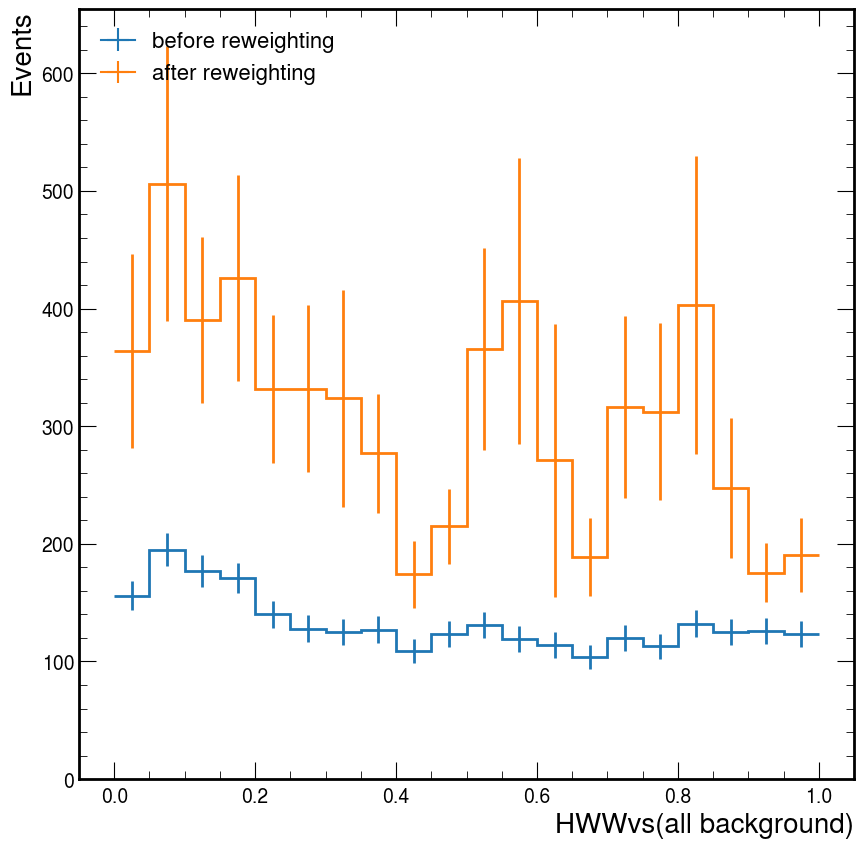

In [25]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler
#implement CMS plot style functions
use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

%matplotlib inline
#step1: plot 
plt.figure(figsize=(10,10))
# plt.hist(eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'], bins=20, range=(0,1), histtype='step', label='before reweighting',density=True);
# plt.hist(eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'], bins=20, range=(0,1), histtype='step', label='after reweighting', weights=eventsEventsID3Prongs4Prongs["LP_weight"],density=True);
nbins, x_min, x_max = 20, 0, 1.0
hist_before = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
hist_before.fill(eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'])
hist_before_value = hist_before.view().value
hist_before_err = np.sqrt(hist_before.view().variance)
hist_after = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
hist_after.fill(eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'],weight=eventsEventsID3Prongs4Prongs["LP_weight"])
hist_after_value = hist_after.view().value
hist_after_err = np.sqrt(hist_after.view().variance)
bins = hist_before.axes[0].edges


hep.histplot(hist_before_value,    bins=bins, yerr=hist_before_err, label= 'before reweighting', lw = 2,edges = False, histtype="step")
hep.histplot(hist_after_value,     bins=bins, yerr=hist_after_err,  label= 'after reweighting', lw = 2,edges = False, histtype="step")


plt.legend(loc='upper left',frameon=False,fontsize=16)
# plt.xlabel(r'$H_{qqqq} / (H_{qqqq} + QCD + Top)$')
plt.xlabel(r'HWWvs(all background)', fontsize=20, ha='right', x=1)
plt.ylabel('Events',fontsize=20, ha='right', y=1)
plt.savefig(f"TaggerDistribution_{test}_woLPR.pdf", bbox_inches='tight')
plt.xticks(size=14)
plt.yticks(size=14)
# plt.show()


In [97]:
import sys, os
sys.path.insert(0, '')
sys.path.append("../")
from utils.Utils import *
""" An example how to use the Lund Plane reweighting  code """



######################## Setup 

#Input file 
fname = "/ospool/cms-user/yuzhe/LPRcalibration/HWWcalibration/LundReweighting/data/example_signal.h5"
#File containing data/MC Lund Plane ratio
f_ratio_name = '/ospool/cms-user/yuzhe/LPRcalibration/HWWcalibration/LundReweighting/data/ratio_2018.root'

f_sig = h5py.File(fname, "r")
f_ratio = ROOT.TFile.Open(f_ratio_name)

#Class to help read input dataset, "Dataset" class defined in Utils.py
d = Dataset(f_sig, dtype = 1)
d.compute_obs() #there may be some dedicated variables inside the .h5 file

#The cut we will compute a SF for 'tau21 < 0.34'
tag_obs = 'tau21'
score_thresh = 0.34


#nominal data/MC Lund plane ratio (3d histogram)
h_ratio = f_ratio.Get("ratio_nom")
#systematic variations
h_ratio_sys_up = f_ratio.Get("ratio_sys_tot_up")
h_ratio_sys_down = f_ratio.Get("ratio_sys_tot_down")
#MC ratio of b to light quarks
b_light_ratio = f_ratio.Get("h_bl_ratio")


#directory of pt extrapolation fits
f_ratio.cd('pt_extrap')
rdir = ROOT.gDirectory #get the present working directory and give it to rdir

#Main class for reweighting utilities
LP_rw = LundReweighter(pt_extrap_dir = rdir)

max_evts = 1000
score = getattr(d, tag_obs)[:max_evts]
score_cut = score < score_thresh


#Number of toys for statistical and pt extrapolation uncertainties
nToys = 100
#Noise vectors used to to generate the toys
#NOTE the same vector has to be used for the whole sample/signal file for the toys to be consistent 
rand_noise = np.random.normal(size = (nToys, h_ratio.GetNbinsX(), h_ratio.GetNbinsY(), h_ratio.GetNbinsZ()))
pt_rand_noise = np.random.normal(size = (nToys, h_ratio.GetNbinsY(), h_ratio.GetNbinsZ(), 3))


################### Compute reweighting factors

#PF candidates in the AK8 jet
pf_cands = d.get_masked("jet1_PFCands").astype(np.float64)[:max_evts]

#Generator level quarks from hard process
gen_parts = d.get_masked('gen_info')[:max_evts]
gen_parts_eta_phi = gen_parts[:,:,1:3]
gen_parts_pdg_ids = gen_parts[:,:,3]

B_PDG_ID = 5

ak8_jets = d.get_masked('jet_kinematics')[:max_evts][:,2:6].astype(np.float64)


#Nominal event weights of the MC, assume every event is weight '1' for this example
weights_nom = np.ones(max_evts)

LP_weights = []
LP_weights_sys_up = []
LP_weights_sys_down = []
stat_smeared_weights = []
pt_smeared_weights = []
b_weights_up = []
b_weights_down = []
bad_matches = []


for i,cands in enumerate(pf_cands):
    print("now processing:",i)
    #Get the subjets, splittings and checking matching based on PF candidates in the jet and gen-level quarks
    subjets, splittings, bad_match, deltaRs = LP_rw.get_splittings_and_matching(cands, gen_parts_eta_phi[i], ak8_jets[i])

    #Gets the nominal LP reweighting factor for this event and statistical + pt extrapolation toys
    LP_weight, stat_smeared_weight, pt_smeared_weight = LP_rw.reweight_lund_plane(h_rw = h_ratio, subjets = subjets, splittings = splittings,
            rand_noise = rand_noise, pt_rand_noise = pt_rand_noise, )
    #Now get systematic variations
    LP_weight_sys_up,_,_ = LP_rw.reweight_lund_plane(h_rw = h_ratio_sys_up, subjets = subjets, splittings = splittings)
    LP_weight_sys_down,_,_ = LP_rw.reweight_lund_plane(h_rw = h_ratio_sys_down, subjets = subjets, splittings = splittings)


    #compute special systematic for subjets matched to b quarks
    #not needed if signal does not specifically produce b quark subjets
    
    gen_bs = [j for j in range(len(gen_parts_pdg_ids[i])) if abs(gen_parts_pdg_ids[i,j]) == B_PDG_ID]

    if(len(gen_bs) == 0): b_rw = 1.0
    else:
        dists = get_subjet_dist(gen_parts_eta_phi[i,gen_bs,1:3], np.array(subjets)[:,1:3])

        b_matches = []
        #which subjet is each quark closest to
        j_closest = np.amin(dists, axis = 0)
        j_which = np.argmin(dists, axis = 0)
        b_matches = np.unique(j_which[j_closest < deltaR_cut])

        #reweight only subjets matched to b quarks
        if(len(b_matches) > 0):
            b_subjet = [subjet[j] for j in range(len(subjet)) if j in b_matches]
            b_split  = [split[j]  for j in range(len(split)) if split[j][0] in b_matches]

            b_rw, _,_   = LP_rw.reweight_lund_plane(b_light_ratio, subjets = b_subjet, splittings = b_split, sys_str = 'bquark')

        else: b_rw = 1.0

    b_weights_up.append(LP_weight * b_rw)
    b_weights_down.append(LP_weight / b_rw)


    LP_weights.append(LP_weight)
    stat_smeared_weights.append(stat_smeared_weight)
    pt_smeared_weights.append(pt_smeared_weight)

    LP_weights_sys_up.append(LP_weight_sys_up)
    LP_weights_sys_down.append(LP_weight_sys_down)
    bad_matches.append(bad_match)



############### Normalize weights to preserve normalization of the MC sample

#The nominal Lund Plane correction event weights
LP_weights = LP_rw.normalize_weights(LP_weights) * weights_nom 

#Toy variations for stat and pt uncertainties
stat_smeared_weights = LP_rw.normalize_weights(stat_smeared_weights) * weights_nom.reshape(max_evts, 1)
pt_smeared_weights = LP_rw.normalize_weights(pt_smeared_weights) * weights_nom.reshape(max_evts,1)

#Systematic up/down variations
LP_weights_sys_up = LP_rw.normalize_weights(LP_weights_sys_up) * weights_nom
LP_weights_sys_down = LP_rw.normalize_weights(LP_weights_sys_down) * weights_nom


#b quark systematic up/down variations
b_weights_up = LP_rw.normalize_weights(b_weights_up) * weights_nom
b_weights_down = LP_rw.normalize_weights(b_weights_down) * weights_nom



############### Compute efficiences and uncertainties


#Efficiency of the cut in nominal MC
eff_nom = np.average(score_cut, weights = weights_nom)

#Efficiency of the cut after the Lund Plane reweighting
eff_rw = np.average(score_cut, weights = LP_weights)

#Nominal 'scale factor'
SF = eff_rw / eff_nom

print("Nominal efficiency %.3f, Corrected efficiency %.3f, SF (corrected / nom) %.3f" % (eff_nom, eff_rw, SF))

#NOTE, better to use corrected efficiency computed separately for each sample rather than a single 'SF'


#Compute efficiency for each of the stat/pt toys
eff_toys = []
pt_eff_toys = []
for i in range(nToys):
    eff = np.average(score_cut, weights = stat_smeared_weights[:,i])
    eff_toys.append(eff)

    eff1 = np.average(score_cut, weights = pt_smeared_weights[:,i])
    pt_eff_toys.append(eff1)

#Compute stat and pt uncertainty based on variation in the toys
toys_mean = np.mean(eff_toys)
toys_std = np.std(eff_toys)
pt_toys_mean = np.mean(pt_eff_toys)
pt_toys_std = np.std(pt_eff_toys)

eff_stat_unc = (abs(toys_mean - eff_rw)  + toys_std) 
eff_pt_unc = (abs(pt_toys_mean - eff_rw) + pt_toys_std)

print("Stat variation toys eff. avg %.3f, std dev %.3f" % (toys_mean, toys_std))
print("Pt variation toys eff. avg %.3f, std dev %.3f" % (pt_toys_mean, pt_toys_std))


#Compute difference in efficiency due to weight variations as uncertainty
def get_uncs(score_cut, weights_up, weights_down, eff_baseline):
    eff_up =  np.average(score_cut, weights = weights_up)
    eff_down =  np.average(score_cut, weights = weights_down)

    unc_up = eff_up - eff_baseline
    unc_down = eff_down - eff_baseline 
    return unc_up, unc_down


#Compute efficiency of systematic variations
sys_unc_up, sys_unc_down = get_uncs(score_cut, LP_weights_sys_up, LP_weights_sys_down, eff_rw)
b_unc_up, b_unc_down = get_uncs(score_cut, b_weights_up, b_weights_down, eff_rw)


#matching uncertainty, taken as a fractional uncertainty on efficiency
bad_match_frac = np.mean(bad_matches)
bad_match_unc = bad_match_frac * eff_rw


############ Results
print("\n\nCalibrated efficiency  is %.2f +/- %.2f  (stat) +/- %.2f (pt) %.2f/%.2f (sys) %.2f/%.2f (bquark) +/- %.2f (matching)  \n\n"  % 
        (eff_rw, eff_stat_unc, eff_pt_unc, sys_unc_up, sys_unc_down, b_unc_up, b_unc_down, bad_match_unc))
f_ratio.Close()


now processing: 0
now processing: 1
now processing: 2
now processing: 3
now processing: 4
now processing: 5
now processing: 6
now processing: 7
now processing: 8
now processing: 9
now processing: 10
now processing: 11
now processing: 12
now processing: 13
now processing: 14
now processing: 15
now processing: 16
now processing: 17
now processing: 18
now processing: 19
now processing: 20
now processing: 21
now processing: 22
now processing: 23
now processing: 24
now processing: 25
now processing: 26
now processing: 27
now processing: 28
now processing: 29
now processing: 30
now processing: 31
now processing: 32
now processing: 33
now processing: 34
now processing: 35
now processing: 36
now processing: 37
now processing: 38
now processing: 39
now processing: 40
now processing: 41
now processing: 42
now processing: 43
now processing: 44
now processing: 45
now processing: 46
now processing: 47
now processing: 48
now processing: 49
now processing: 50
now processing: 51
now processing: 52
now

In [225]:
events_final.fields

['GenFatJetSVs',
 'GenPart',
 'LHEPdfWeight',
 'GenJetAK15',
 'SubJet',
 'event',
 'btagWeight',
 'DeepMETResponseTune',
 'GenMET',
 'JetPFCands',
 'Jet',
 'SoftActivityJetNjets10',
 'FatJetPFCands',
 'GenVisTau',
 'L1',
 'LHE',
 'GenJetAK8',
 'GenIsolatedPhoton',
 'SubGenJetAK8',
 'IsoTrack',
 'Electron',
 'CaloMET',
 'PuppiMET',
 'LHEPart',
 'SV',
 'GenJetCands',
 'SoftActivityJetHT2',
 'LHEWeight',
 'PFCands',
 'GenJet',
 'GenVtx',
 'Muon',
 'SoftActivityJetNjets5',
 'AK15PuppiSubJet',
 'HLT',
 'SoftActivityJetHT5',
 'OtherPV',
 'Tau',
 'HLTriggerFirstPath',
 'SoftActivityJetHT',
 'GenDressedLepton',
 'AK15Puppi',
 'Flag',
 'LHEReweightingWeight',
 'SoftActivityJetHT10',
 'Pileup',
 'FatJet',
 'FatJetSVs',
 'SoftActivityJet',
 'SoftActivityJetNjets2',
 'fixedGridRhoFastjetCentralCalo',
 'MET',
 'fixedGridRhoFastjetCentralNeutral',
 'JetSVs',
 'fixedGridRhoFastjetAll',
 'CorrT1METJet',
 'TrigObj',
 'L1Reco',
 'PV',
 'run',
 'FsrPhoton',
 'L1simulation',
 'GenCands',
 'LHEScaleWeight'

In [226]:
events_final.FatJet.inclParTMDV1_probHWqqWev0c

<Array [[0.00102, 0.00101, ... 0.000164]] type='1026 * var * float32[parameters=...'>

In [228]:
def get_one_file_score_HWW(events_final):
    eventsScoreFatjet = events_final
    # eventsScoreEventsID = eventsScore.arrays(['run', 'luminosityBlock', 'event', 'GenPart_pt','GenPart_eta','GenPart_phi','GenPart_mass','GenPart_genPartIdxMother','GenPart_pdgId', "GenPart_status", "FatJet_pt","FatJet_eta","FatJet_phi","FatJet_mass", "FatJetPFCands_jetIdx", "FatJetPFCands_pFCandsIdx", "PFCands_pt", "PFCands_eta", "PFCands_phi", "PFCands_mass"], library="pd")
    # eventsScoreFatjet = eventsScore.arrays(['FatJet_inclParTMDV1_probHWqqWev0c', 'FatJet_inclParTMDV1_probHWqqWev1c', 'FatJet_inclParTMDV1_probHWqqWmv0c', 'FatJet_inclParTMDV1_probHWqqWmv1c', 'FatJet_inclParTMDV1_probHWqqWq0c', 'FatJet_inclParTMDV1_probHWqqWq1c', 'FatJet_inclParTMDV1_probHWqqWq2c', 'FatJet_inclParTMDV1_probHWqqWqq0c', 'FatJet_inclParTMDV1_probHWqqWqq1c', 'FatJet_inclParTMDV1_probHWqqWqq2c', 'FatJet_inclParTMDV1_probHWqqWtauev0c', 'FatJet_inclParTMDV1_probHWqqWtauev1c', 'FatJet_inclParTMDV1_probHWqqWtauhv0c', 'FatJet_inclParTMDV1_probHWqqWtauhv1c', 'FatJet_inclParTMDV1_probHWqqWtaumv0c', 'FatJet_inclParTMDV1_probHWqqWtaumv1c'])
    HqqqqVsQcdTop = eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWev0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWev1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWmv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWmv1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq2c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq2c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauev0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauev1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauhv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauhv1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtaumv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtaumv1c
    #actually here it's HWWvsAll background tagger, but still named HqqqqVsQCDTop    
    leading_HqqqqVsQcdTop = ak.Array(ak.max(HqqqqVsQcdTop, axis=1) )#because each event has more than 1 jet
    eventsScoreFatjet["HqqqqVsQcdTop"] = list(leading_HqqqqVsQcdTop) # why use list here?
    # eventsScoreFatjet["HqqqqVsQcdTop"] = eventsScoreFatjet["HqqqqVsQcdTop"]
    return eventsScoreFatjet 
a = get_one_file_score_HWW(events_final)

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 [Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100'),
  Text(0, 120.0, '120'),
  Text(0, 140.0, '140')])

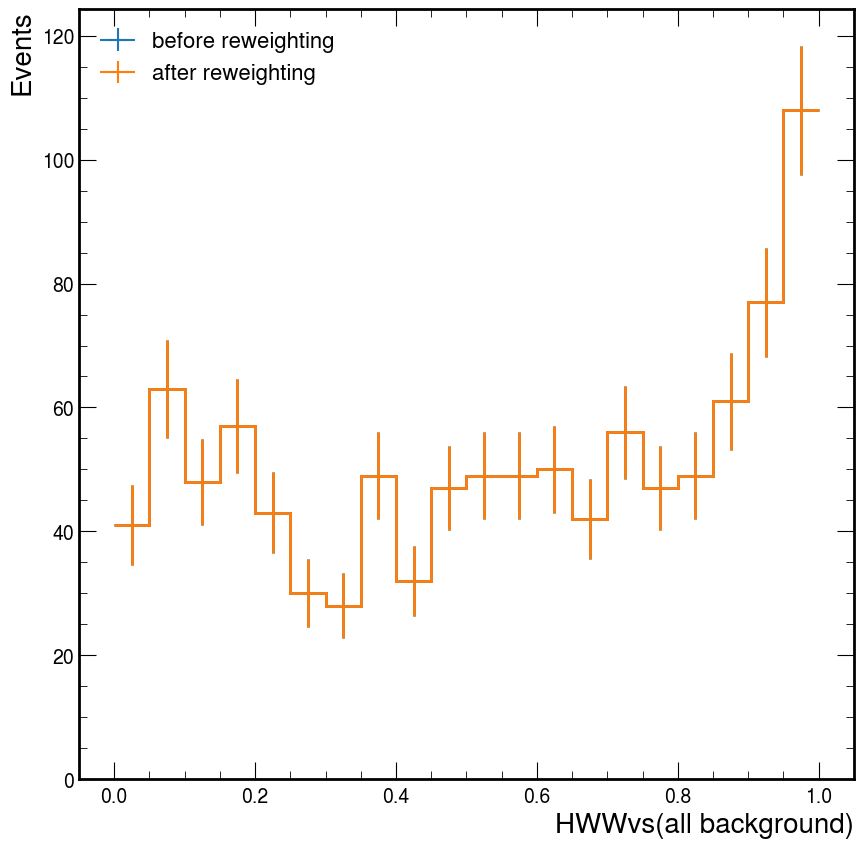

In [230]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler
#implement CMS plot style functions
use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

%matplotlib inline
#step1: plot 
plt.figure(figsize=(10,10))
# plt.hist(eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'], bins=20, range=(0,1), histtype='step', label='before reweighting',density=True);
# plt.hist(eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'], bins=20, range=(0,1), histtype='step', label='after reweighting', weights=eventsEventsID3Prongs4Prongs["LP_weight"],density=True);
nbins, x_min, x_max = 20, 0, 1.0
hist_before = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
hist_before.fill(a['HqqqqVsQcdTop'])
hist_before_value = hist_before.view().value
hist_before_err = np.sqrt(hist_before.view().variance)
hist_after = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
hist_after.fill(a['HqqqqVsQcdTop'])
hist_after_value = hist_after.view().value
hist_after_err = np.sqrt(hist_after.view().variance)
bins = hist_before.axes[0].edges


hep.histplot(hist_before_value,    bins=bins, yerr=hist_before_err, label= 'before reweighting', lw = 2,edges = False, histtype="step")
hep.histplot(hist_after_value,     bins=bins, yerr=hist_after_err,  label= 'after reweighting', lw = 2,edges = False, histtype="step")


plt.legend(loc='upper left',frameon=False,fontsize=16)
# plt.xlabel(r'$H_{qqqq} / (H_{qqqq} + QCD + Top)$')
plt.xlabel(r'HWWvs(all background)', fontsize=20, ha='right', x=1)
plt.ylabel('Events',fontsize=20, ha='right', y=1)
plt.savefig(f"TaggerDistribution_woLPR.pdf", bbox_inches='tight')
plt.xticks(size=14)
plt.yticks(size=14)
# plt.show()
